In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from utils import *

# Neural Networks
class SequenceModel(nn.Module):
    def __init__(self, representationSize, actionSize, recurrentStateSize):
        super().__init__()
        self.representationSize = representationSize
        self.actionSize = actionSize
        self.recurrentStateSize = recurrentStateSize
        self.recurrent = nn.GRUCell(representationSize + actionSize, recurrentStateSize)

    def forward(self, representation, action, recurrentState):
        return self.recurrent(torch.cat((representation, action), -1), recurrentState)
    
    def initializeRecurrentState(self):
        return torch.zeros(self.recurrentStateSize)

class PriorNet(nn.Module):
    def __init__(self, inputSize, representationClasses=16):
        super().__init__()
        self.representationSize = representationClasses
        self.mlp = sequentialModel1D(inputSize, [256, 256], representationClasses**2)
    
    def forward(self, x):
        logits = self.mlp(x)
        stateMatrix = logits.view(-1, self.representationSize, self.representationSize)
        _, indices = torch.max(stateMatrix, dim=-1)
        representation = F.one_hot(indices, num_classes=self.representationSize)
        return representation.view(-1), logits
    
class PosteriorNet(nn.Module):
    def __init__(self, inputSize, representationClasses=16):
        super().__init__()
        self.representationSize = representationClasses
        self.mlp = sequentialModel1D(inputSize, [256, 256], representationClasses**2)
    
    def forward(self, x):
        logits = self.mlp(x)
        stateMatrix = logits.view(-1, self.representationSize, self.representationSize)
        _, indices = torch.max(stateMatrix, dim=-1)
        representation = F.one_hot(indices, num_classes=self.representationSize)
        return representation.view(-1), logits

class ConvEncoder(nn.Module):
    def __init__(self, inputShape, outputSize):
        super(ConvEncoder, self).__init__()
        c, h, w = inputShape
        self.convolutionalNet = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, h/2, w/2)
            nn.Tanh(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, h/4, w/4)
            nn.Tanh(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, h/8, w/8)
            nn.Tanh(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, h/16, w/16)
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(256 * (h // 16) * (w // 16), outputSize),
            nn.Tanh(),
        )

    def forward(self, obs):
        return self.convolutionalNet(obs/255.0)

class ConvDecoder(nn.Module):
    def __init__(self, inputSize, outputShape):
        super(ConvDecoder, self).__init__()
        self.outputShape = outputShape
        c, h, w = outputShape
        self.fc = nn.Sequential(
            nn.Linear(inputSize, 256 * (h // 16) * (w // 16)),
            nn.Tanh(),
        )
        self.deconvolutionalNet = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, h/8, w/8)
            nn.Tanh(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, h/4, w/4)
            nn.Tanh(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, h/2, w/2)
            nn.Tanh(),
            nn.ConvTranspose2d(32, c, kernel_size=4, stride=2, padding=1),  # Output: (c, h, w)
            nn.Sigmoid(),  # Output pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.fc(x)
        batchSize = x.size(0)
        c, h, w = 256, self.outputShape[1] // 16, self.outputShape[2] // 16
        x = x.view(batchSize, c, h, w)
        return self.deconvolutionalNet(x)


In [2]:
import torch
import torch.nn as nn
import torch.functional as F
from utils import *
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('episode_0_data.pkl', 'rb') as f:
    data = pickle.load(f)
observations = data['observations'].to(device)
actions = data['actions'].float().to(device)
episodeLength = len(actions)

representationClasses = 16
representationSize = representationClasses ** 2
actionSize = 3
recurrentStateSize = 256
compressedObservationsSize = 256
obsShape = (3, 96, 96)

convEncoder     = ConvEncoder(obsShape, compressedObservationsSize).to(device)
convDecoder     = ConvDecoder(representationSize + recurrentStateSize, obsShape).to(device)
sequenceModel   = SequenceModel(representationSize, actionSize, recurrentStateSize).to(device)
priorNet        = PriorNet(recurrentStateSize, representationClasses).to(device)
posteriorNet    = PosteriorNet(recurrentStateSize + compressedObservationsSize, representationClasses).to(device)

In [9]:
encodedObservations = convEncoder(observations)
recurrentState = sequenceModel.initializeRecurrentState().to(device)

posteriorNetOutputs = []
recurrentStates = [recurrentState]
priorNetLogits = []
posteriorNetLogits = []

for timestep in range(episodeLength):
    posteriorNetOutput, posteriorNetCurrentLogits = posteriorNet(torch.cat((recurrentStates[timestep], encodedObservations[timestep]), -1))
    posteriorNetOutputs.append(posteriorNetOutput)
    posteriorNetLogits.append(posteriorNetCurrentLogits)

    recurrentState = sequenceModel(posteriorNetOutputs[timestep].detach(), actions[timestep], recurrentStates[timestep])
    recurrentStates.append(recurrentState)

    _, priorNetCurrentLogits = priorNet(recurrentStates[timestep])
    priorNetLogits.append(priorNetCurrentLogits)

posteriorNetOutputs = torch.stack(posteriorNetOutputs)  # [episodeLength    , representationSize]
recurrentStates = torch.stack(recurrentStates)          # [episodeLength + 1, recurrentStateSize]
priorNetLogits = torch.stack(priorNetLogits)            # [episodeLength    , representationSize]
posteriorNetLogits = torch.stack(posteriorNetLogits)      # [episodeLength    , representationSize]
fullStateRepresentations = torch.cat((recurrentStates[1:], posteriorNetOutputs), -1)

reconstructedObservations = convDecoder(fullStateRepresentations)

reconstructionLoss = F.mse_loss(reconstructedObservations, observations[1:], reduction="none").mean(dim=[-1, -2, -3]).mean() # why is it 255 and 256. In theory we should be able to reconstruct all 256
priorNetLoss = F.mse_loss(priorNetLogits, posteriorNetLogits.detach())


In [14]:
reconstructionLoss.mean(dim=[-1, -2, -3]).mean().shape

torch.Size([255])

In [7]:
observations.shape

torch.Size([256, 3, 96, 96])

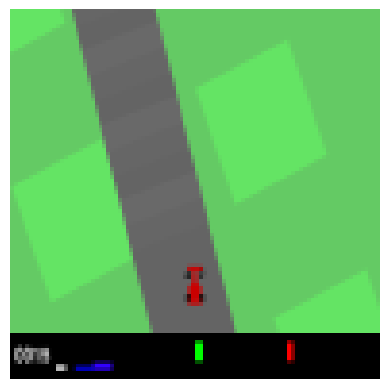

In [5]:
displayImage(np.transpose(observations.cpu().numpy()[50], (1, 2, 0)))